#  AT&T Spam Detector - Random Under Sampler


# EDA

In [1]:
# prelude

import pandas as pd
import re
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go

# For Random Under Sampler
from imblearn.under_sampling import RandomUnderSampler 
from collections import Counter


from pathlib import Path
# k_CurrentDir  = Path(__file__).parent    # __file__ is not known in Jupyter context
k_Current_dir   = Path.cwd()
k_AssetsDir     = "assets"
k_Gold          = 1.618                    # gold number for ratio
k_Width         = 12
k_Height        = k_Width/k_Gold
k_WidthPx       = 1024
k_HeightPx      = k_WidthPx/k_Gold
k_random_state  = 42
k_test_size     = 0.3
k_num_words     = 1_000                    # the number of most freq words to keep during tokenization
k_epochs        = 50                       # I tried 10, 20, 50 and 100

In [2]:
# -----------------------------------------------------------------------------
def quick_View(df: pd.DataFrame) -> pd.DataFrame:

    """
    Generates a summary DataFrame for each column in the input DataFrame.

    This function analyzes each column in the given DataFrame and creates a summary that includes
    data type, number of null values, percentage of null values, number of non-null values, 
    number of distinct values, min and max values, outlier bounds (for numeric columns),
    and the frequency of distinct values.

    Args:
        df (pd.DataFrame): The input DataFrame to analyze.

    Returns:
        pd.DataFrame: A DataFrame containing the summary of each column from the input DataFrame. 
                      Each row in the resulting DataFrame represents a column from the input DataFrame
                      with the following information:
                      - "name": Column name
                      - "dtype": Data type of the column
                      - "# null": Number of null values
                      - "% null": Percentage of null values
                      - "# NOT null": Number of non-null values
                      - "distinct val": Number of distinct values
                      - "-3*sig": Lower bound for outliers (mean - 3*std) for numeric columns
                      - "min": Minimum value for numeric columns
                      - "max": Maximum value for numeric columns
                      - "+3*sig": Upper bound for outliers (mean + 3*std) for numeric columns
                      - "distinct val count": Dictionary of distinct value counts or top 10 values for object columns
    """

    summary_lst = []
  
    for col_name in df.columns:
        col_dtype               = df[col_name].dtype
        num_of_null             = df[col_name].isnull().sum()
        percent_of_null         = num_of_null/len(df)
        num_of_non_null         = df[col_name].notnull().sum()
        num_of_distinct_values  = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts    = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts  = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        if col_dtype != "object":
            max_of_col = df[col_name].max()
            min_of_col = df[col_name].min()
            outlier_hi = df[col_name].mean() + 3*df[col_name].std()
            outlier_lo = df[col_name].mean() - 3*df[col_name].std()
        else:
            max_of_col = -1
            min_of_col =  1
            outlier_hi = -1
            outlier_lo =  1

        summary_lst.append({
            "name"                : col_name,
            "dtype"               : col_dtype,
            "# null"              : num_of_null,
            "% null"              : (100*percent_of_null).round(2),
            "# NOT null"          : num_of_non_null,
            "distinct val"        : num_of_distinct_values,
            "-3*sig"              : round(outlier_lo,2) ,
            "min"                 : round(min_of_col,2),
            "max"                 : round(max_of_col,2),
            "+3*sig"              : round(outlier_hi,2) ,
            "distinct val count"  : distinct_values_counts
        })

    df_tmp = pd.DataFrame(summary_lst)
    return df_tmp

In [3]:
# -----------------------------------------------------------------------------
# drop empty cols and duplicates, rename cols...
def cleaner(df):
    df.drop(columns="Unnamed: 2", inplace=True)
    df.drop(columns="Unnamed: 3", inplace=True)
    df.drop(columns="Unnamed: 4", inplace=True)

    df.drop_duplicates(inplace=True)

    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace("/", "_")

    df.rename(columns={"v1": "target"}, inplace=True)
    df.rename(columns={"v2": "text"}, inplace=True)

    return df

In [4]:
# df = pd.read_csv("https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv", encoding="cp1252")
df = pd.read_csv(k_Current_dir / k_AssetsDir / "spam.csv", encoding="cp1252")
print(f"\n\nPreview of the dataset (raw) :")
display(df.head())

df = cleaner(df)
# print(df.shape)

print(f"\n\nPreview of the initial dataset :")
display(df.head())

print(f"\n\nThe dataset consists of :")
print(f"\t{len(df.shape):>9_} dimensions")
print(f"\t{df.shape[0]:>9_} observations")
print(f"\t{df.shape[1]:>9_} features    ")

print(f"\n\nIt's a binary classification problem")

df_types = pd.DataFrame ({
  "types" : df.dtypes.value_counts()
})
df_types["as_%"] = (100 * df_types["types"]/df_types["types"].sum()).round(2)

print(f"\n\n% of data type :")
display(df_types)

df_tmp = quick_View(df)
print(f"\n\nQuickView :")
display(df_tmp.sort_values(by="# null", ascending=False))   

print(f"\n\n% of missing values :")
display(round(df.isnull().sum()/len(df)*100, 2))



Preview of the dataset (raw) :


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN




Preview of the initial dataset :


,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."




The dataset consists of :
	        2 dimensions
	    5_169 observations
	        2 features    


It's a binary classification problem


% of data type :


,types,as_%
object,2,100.0




QuickView :


,name,dtype,# null,% null,# NOT null,distinct val,-3*sig,min,max,+3*sig,distinct val count
0,target,object,0,0.0,5169,2,1,1,-1,-1,"{'ham': 4516, 'spam': 653}"
1,text,object,0,0.0,5169,5169,1,1,-1,-1,"{'Go until jurong point, crazy.. Available onl..."




% of missing values :


target    0.0
text      0.0
dtype: float64

## <span style="color:orange"><b>Comments :</b></span>
* There is no missing values
* 5k observations. Will it be enough ?
* Unbalanced target

## Spam & ham balance

Nb spam :     653
Nb ham  :   4_516


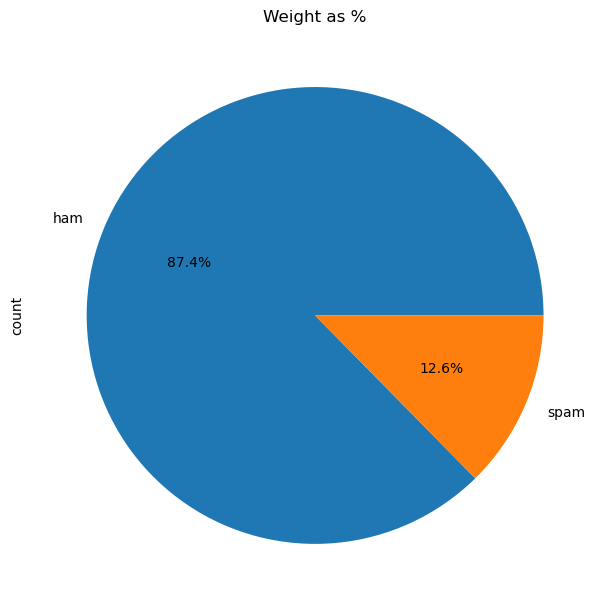

In [5]:
counts = df["target"].value_counts()
print(f"Nb spam : {counts['spam']:>7_}")
print(f"Nb ham  : {counts['ham']:>7_}")

_ = counts.plot.pie(title="Weight as %", autopct="%1.1f%%", figsize=(k_Width, k_Height))

### <span style="color:orange"><b>Comments :</b></span>
* No surprise, the target is heavily unbalanced

# Text processing


## How ham and spam text look like ?

In [6]:
print(f"\n\nHAM : ")
# pd.set_option("display.max_colwidth", 1000)
# print(df[df["target"]=="ham"].head(20))
print(df[df["target"]=="ham"].head(20).to_string())



HAM : 
   target                                                                                                                                                                                                  text
0     ham                                                                                       Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1     ham                                                                                                                                                                         Ok lar... Joking wif u oni...
3     ham                                                                                                                                                     U dun say so early hor... U c already then say...
4     ham                                                                                                                                         Nah I don't t

In [7]:
print(f"\n\nSPAM : ")
print(df[df["target"]=="spam"].head(20).to_string())



SPAM : 
    target                                                                                                                                                                          text
2     spam                   Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
5     spam                          FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
8     spam                WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
9     spam                    Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030
11    spam                                      SIX chances to wi

## Cleaning

In [8]:
# The 2 lines below can help to print the punctuation signs
# import string 
# string.punctuation

# Remove punctuation  
df["clean_docs"] = df["text"].apply(lambda x: re.sub("[!\"#$%&()*+,-./:;<=>?@\[\]^_`{|}~\\\]+"," ", x)) 

# fillna() makes sure NA is replaced with "" so that lowering case do not generate error
df["clean_docs"] = df["clean_docs"].fillna("").apply(lambda x: x.lower())

# df["clean_docs"].head(20)
df


,target,text,clean_docs
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only i...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i don't think he goes to usf he lives aro...
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?,will ì b going to esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",pity was in mood for that so any other sug...
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...


## Tokenization

In [9]:
nlp = en_core_web_sm.load()

# Tokenize the cleaned document
df["tokenized_docs"] = df["clean_docs"].fillna("").apply(lambda x: nlp(x))

# remove stop-words, replace words with their lemma
df["tokenized_docs"] = df["tokenized_docs"].apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])
# df["tokenized_docs"].head(20)

# clean up tokenized documents
df["clean_tokens"] = [" ".join(x) for x in df["tokenized_docs"]]

# set the target as boolean value (spam=1) 
df["target"] = df["target"].map({"ham":0,"spam":1})
df


,target,text,clean_docs,tokenized_docs,clean_tokens
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only i...,"[jurong, point, , crazy, , available, bugis,...",jurong point crazy available bugis n great...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, , joke, wif, u, oni]",ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, early, hor, , u, c]",u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don't think he goes to usf he lives aro...,"[nah, think, go, usf, , live]",nah think go usf live
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,"[2nd, time, try, 2, contact, u, , u, win, å£7...",2nd time try 2 contact u u win å£750 pound p...
5568,0,Will Ì_ b going to esplanade fr home?,will ì b going to esplanade fr home,"[ì, , b, go, esplanade, fr, home]",ì b go esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",pity was in mood for that so any other sug...,"[pity, , mood, , suggestion]",pity mood suggestion
5570,0,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...,"[guy, bitching, act, like, interested, buy, we...",guy bitching act like interested buy week give...


## Word Cloud

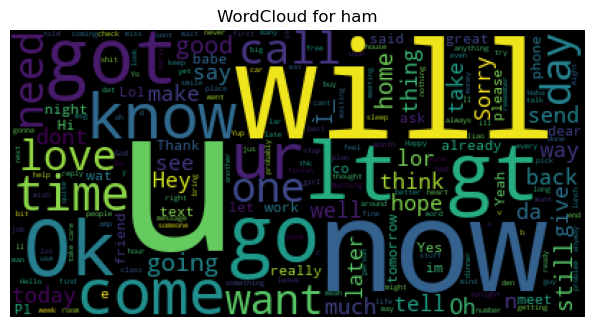

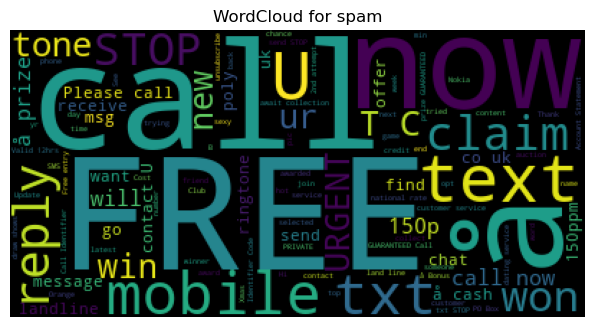

In [10]:
for i in set(df["target"]):
    words = ""
    for doc in df[df["target"] == i]["text"]:
        words += doc + " "
    wordcloud = WordCloud().generate(words)
    plt.figure(figsize = (k_Height, k_Width))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"WordCloud for {'spam' if i==1 else 'ham'}")
    plt.show()

### <span style="color:orange"><b>Comments :</b></span>

* With no surprise "free", "call", "now"... are dominant in spams sms
* Surprisingly "sex" and "viagra" are missing 😁

## Word occurrences

In [11]:
def word_occurences_report(target):
    df_tmp = " ".join(df[df["target"] == target]["clean_tokens"])
    df_tmp = pd.DataFrame(df_tmp.split(" "))
    df_tmp = df_tmp.value_counts(ascending=False)

    df_tmp = df_tmp.reset_index()  
    df_tmp.columns = ["word", "occurrences"]  
    df_tmp.set_index("word", inplace=True)  
    display(df_tmp)

    # print(f"About words in ham :")
    print(f"{len(df_tmp):>6_} differents words")
    print(f"{df_tmp['occurrences'].sum():>6_} occurrences")
    pareto = int(df_tmp['occurrences'].sum()*0.8)
    print(f"{pareto:>6_} = 80% of thoses occurrences")

    i = 100
    while df_tmp['occurrences'].head(i).sum()<pareto:
        i+=100

    print(f"{i:6_} ({100*i/len(df_tmp):.0f} %) words are needed to cover 80% of the occurrences")
    print(f"\n\n\n")
    return

In [12]:
print(f"About words in spam :")
word_occurences_report(1)

print(f"About words in ham :")
word_occurences_report(0)


About words in spam :


,occurrences
word,
,4422
free,195
2,171
txt,142
u,141
...,...
complete,1
complementary,1
compensation,1


 2_558 differents words
15_527 occurrences
12_421 = 80% of thoses occurrences
   500 (20 %) words are needed to cover 80% of the occurrences




About words in ham :


,occurrences
word,
,15231
u,902
go,310
2,302
come,299
...,...
breath,1
breakin,1
breakfast,1


 5_728 differents words
47_980 occurrences
38_384 = 80% of thoses occurrences
   700 (12 %) words are needed to cover 80% of the occurrences






## Encoding

In [13]:
# instantiate the tokenizer. oov_token="out_of_vocab"
# keep the 1_000 most frequents words during tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=k_num_words, oov_token="_UNKNOWN_") 
tokenizer.fit_on_texts(df["clean_tokens"])
df["sms_encoded"] = tokenizer.texts_to_sequences(df["clean_tokens"])
df


,target,text,clean_docs,tokenized_docs,clean_tokens,sms_encoded
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only i...,"[jurong, point, , crazy, , available, bugis,...",jurong point crazy available bugis n great...,"[1, 253, 446, 469, 922, 37, 60, 272, 923, 75, ..."
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, , joke, wif, u, oni]",ok lar joke wif u oni,"[14, 207, 496, 301, 2, 1]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",free entry 2 wkly comp win fa cup final tkts 2...,"[15, 373, 3, 763, 716, 46, 1, 1, 497, 1, 1, 1,..."
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, early, hor, , u, c]",u dun early hor u c,"[2, 129, 154, 1, 2, 56]"
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don't think he goes to usf he lives aro...,"[nah, think, go, usf, , live]",nah think go usf live,"[717, 24, 5, 660, 175]"
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,"[2nd, time, try, 2, contact, u, , u, win, å£7...",2nd time try 2 contact u u win å£750 pound p...,"[310, 19, 57, 3, 106, 2, 2, 46, 1, 335, 84, 3,..."
5568,0,Will Ì_ b going to esplanade fr home?,will ì b going to esplanade fr home,"[ì, , b, go, esplanade, fr, home]",ì b go esplanade fr home,"[45, 97, 5, 1, 582, 28]"
5569,0,"Pity, * was in mood for that. So...any other s...",pity was in mood for that so any other sug...,"[pity, , mood, , suggestion]",pity mood suggestion,"[1, 1, 1]"
5570,0,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...,"[guy, bitching, act, like, interested, buy, we...",guy bitching act like interested buy week give...,"[121, 1, 1, 16, 980, 93, 44, 327, 15]"


## Padding

In [14]:
# Tensorflow cannot create a tensor dataset based on lists
# We have to store encoded sms into a numpy array before creating the tensorflow dataset
# However, not all the sequences are the same length
# This is where `tf.keras.preprocessing.sequence.pad_sequences()` comes in 
# It will add zero padding at the beginning (`padding="pre"`) or at the end (`padding="post"`) of our sequences so they all have equal length
sms_padded = tf.keras.preprocessing.sequence.pad_sequences(df["sms_encoded"], padding="post")
print(sms_padded)
print(sms_padded.shape)

# max_words = df['clean_tokens'].apply(lambda x: len(x.split())).max()
# print(max_words)
# 77

[[  1 253 446 ...   0   0   0]
 [ 14 207 496 ...   0   0   0]
 [ 15 373   3 ...   0   0   0]
 ...
 [  1   1   1 ...   0   0   0]
 [121   1   1 ...   0   0   0]
 [  1 368   0 ...   0   0   0]]
(5169, 77)


## Split

In [15]:
# stratify
X_train, X_test, y_train, y_test = train_test_split(sms_padded, df["target"], test_size = k_test_size, random_state = k_random_state, stratify = df["target"])

# Random Under Sampler on train set


In [16]:

rus = RandomUnderSampler(random_state=k_random_state, replacement=True) # fit predictor and target variable
X_rus, y_rus = rus.fit_resample(X_train, y_train)

print('Original dataset shape:', Counter(y_train))
print('Resample dataset shape', Counter(y_rus))

X_train = X_rus.copy()
y_train = y_rus.copy()
y_train.shape

Original dataset shape: Counter({0: 3161, 1: 457})
Resample dataset shape Counter({0: 457, 1: 457})


(914,)

## Create Tensor

In [17]:
# creates a TensorFlow Dataset object to be used for data loading, batching, shuffling, and preprocessing when training the model
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [18]:
# Create generators, making sure that data are blended/mixed and divided into batches of 64 observations 
train_batch = train_ds.shuffle(len(train_ds)).batch(64)
test_batch = test_ds.shuffle(len(test_ds)).batch(64)

for sms, ham_spam in train_batch.take(1):
  print(sms, ham_spam)

print()
print(sms.shape)

tf.Tensor(
[[126  23 313 ...   0   0   0]
 [  1   1   1 ...   0   0   0]
 [ 15  72 513 ...   0   0   0]
 ...
 [ 21   7 137 ...   0   0   0]
 [ 15 242 293 ...   0   0   0]
 [  1  11   1 ...   0   0   0]], shape=(64, 77), dtype=int32) tf.Tensor(
[0 1 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 0
 0 1 1 1 0 1 1 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 0], shape=(64,), dtype=int64)

(64, 77)


# Using a Baseline Model


In [19]:
sequence_length = sms_padded.shape[1]

model = tf.keras.Sequential([
    # This Embedding layer converts integer-encoded words (from the tokenizer) into dense vectors of size 8 
    # tokenizer.num_words should be equal to k_num_words
    # +1 because TensorFlow reserves an index for padding or the OOV token
    # sms.shape[1] is the length of the input sequence. See the output of the previous cell (77)
    # For the output I tried : 16 8 4 and 2
    # I like 8
    # tf.keras.layers.Embedding(tokenizer.num_words + 1, 8, input_shape=[sms.shape[1],], name="embedding"),
    tf.keras.layers.Embedding(tokenizer.num_words + 1, 8, input_shape=[sequence_length], name="embedding"),

    # Global average pooling
    # Reduces the dimensionality by averaging the vectors across the sequence length
    # The model loose the order of the words but we don't care  
    tf.keras.layers.GlobalAveragePooling1D(),

    # Fully connected (Dense) layer with 16 neurons. 
    # relu activation function introduces non-linearity (this helps the model to capture more complex patterns)
    tf.keras.layers.Dense(16, activation="relu"),

    # Since this is a binary classification problem (based on the sigmoid activation), there's a single output neuron. 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 77, 8)             8008      
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,169
Trainable params: 8,169
Non-trainable params: 0
_________________________________________________________________


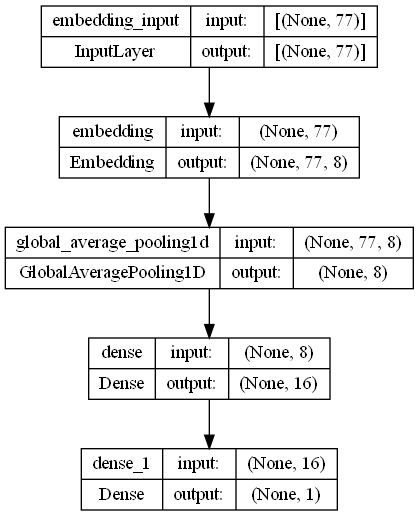

In [20]:
path = Path(f"{k_Current_dir/k_AssetsDir/'basic_arch.png'}")
tf.keras.utils.plot_model(model, path, show_shapes=True)

## <span style="color:orange"><b>Comments :</b></span>

About the number of trainable parameters of the model

```
Inputs                 : 1000 words    (see k_num_words in prelude)
Embedding layer        :  8 neurons => (1000 + 1) * 8 = 8008 params
GlobalAveragePooling1D :    average => no params      =    0 params
Dense layer            : 16 neurons => 8  * 16 + 16   =  144 params
Dense layer            :  1 neuron  => 16 *  1 +  1   =   17 params
                                                TOTAL = 8169 params
```


In [21]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision"), "accuracy"]       # name=... avoid recall_1 for example
)

In [22]:
# history = model.fit(
#     train_batch,
#     epochs = k_epochs,
#     validation_data=test_batch,
# )

In [23]:
confusion_matrices = []

def get_data_from_dataset(dataset):
    features = []
    labels = []
    for batch_features, batch_labels in dataset:
        features.append(batch_features.numpy())
        labels.append(batch_labels.numpy())
    return np.concatenate(features), np.concatenate(labels)

class ConfusionMatrixCallback(tf.keras.callbacks.Callback):             # inherit from tf.keras.callbacks.Callback
    def __init__(self, val_data):
        # store data once
        self.val_data = val_data                                        

    def on_epoch_end(self, epoch, logs=None):
        # extract features and labels from validation set
        val_features, val_labels = get_data_from_dataset(self.val_data)
        
        # make prediction with validation features
        val_pred = (self.model.predict(val_features) > 0.5).astype("int32")
        
        # compute the associated confusion matrix
        cm = confusion_matrix(val_labels, val_pred)

        # flip the 2 lines just to make sure it looks like sklearn.metrics.confusion_matrix
        cm_flipped = np.flipud(cm)
        
        confusion_matrices.append(cm_flipped)

history = model.fit(
    train_batch,
    epochs=k_epochs,
    validation_data=test_batch,
    callbacks=[ConfusionMatrixCallback(test_batch)]
)

Epoch 1/50
15/15 [==============================] - 2s 53ms/step - loss: 0.6922 - recall: 0.4354 - precision: 0.8122 - accuracy: 0.6674 - val_loss: 0.6891 - val_recall: 0.3418 - val_precision: 0.7128 - val_accuracy: 0.8994
Epoch 2/50
15/15 [==============================] - 0s 21ms/step - loss: 0.6902 - recall: 0.0569 - precision: 0.8667 - accuracy: 0.5241 - val_loss: 0.6777 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.8717
Epoch 3/50
15/15 [==============================] - 0s 22ms/step - loss: 0.6874 - recall: 0.0044 - precision: 0.4000 - accuracy: 0.4989 - val_loss: 0.6698 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.8717
Epoch 4/50
15/15 [==============================] - 0s 23ms/step - loss: 0.6841 - recall: 0.0131 - precision: 0.6667 - accuracy: 0.5033 - val_loss: 0.6635 - val_recall: 0.0765 - val_precision: 0.6818 - val_accuracy: 0.8788
Epoch 5/50
15/15 [==============================] - 0s 21ms/step - loss: 0.6792 - recall: 0.

## Evaluating

### <span style="color:orange"><b>Sync point :</b></span>

<p align="center">
<img src="./assets/metrics.png" alt="drawing" width="400"/>
<p>

* Sms identified as spam (=1)
* Can I accept spam in my sms? I don't know...
* Can I accept to see an sms from my beloved CEO classified as spam? No! 
* So I want FP to tend towards 0 and precision $\frac{TP}{TP+FP}$ towards 1 (even if the recall, $\frac{TP}{TP+FN}$, is not that great )
* I decide to favour precision over recall

Just to make sure...
* **Overfitting**
    * If accuracy continues to increase on training but starts to decrease or stagnate on validation
    * this indicates overfitting.

* **Underfitting** 
    * If the loss curves do not decrease 
    * or 
    * If accuracy remains low
    * this could indicate that the model has not yet learned sufficiently.


In [24]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = Path(f"{k_Current_dir/k_AssetsDir/fig_id}.{fig_extension}")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    return

### Loss

Saving figure baseline_rus_loss


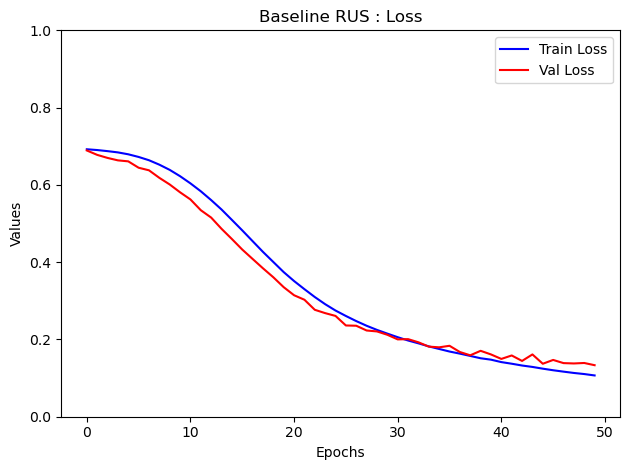

[[0.141373,
  0.137171,
  0.132528,
  0.128866,
  0.124369,
  0.120274,
  0.116673,
  0.113261,
  0.110436,
  0.10682]]

[[0.149587,
  0.158533,
  0.144398,
  0.161203,
  0.137105,
  0.146958,
  0.138764,
  0.137849,
  0.139078,
  0.133346]]

In [25]:
# "val_" stands for validation
# history.history.keys()

plt.plot(history.history["loss"], color="b", label="Train Loss")
plt.plot(history.history["val_loss"], color="r", label="Val Loss")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Baseline RUS : Loss")
plt.legend()
plt.ylim(0,1)
save_fig("baseline_rus_loss", "png")
plt.show()


# display(history.history['loss'][-10:])
display([[round(f, 6) for f in history.history['loss'][-10:]]])
display([[round(f, 6) for f in history.history['val_loss'][-10:]]])


### Accuracy

Saving figure baseline_rus_accuracy


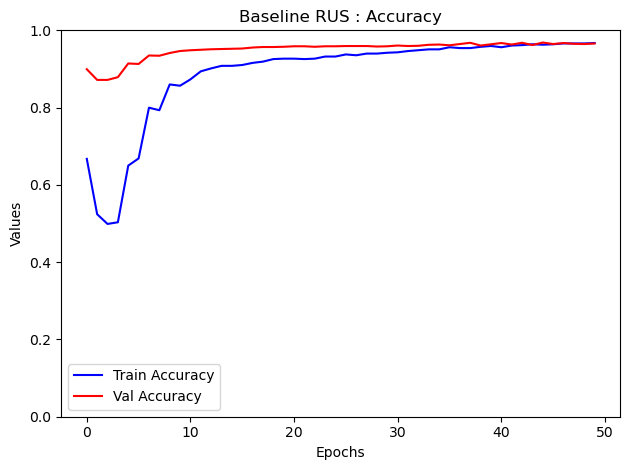

[[0.956236,
  0.960613,
  0.961707,
  0.963895,
  0.962801,
  0.963895,
  0.966083,
  0.966083,
  0.966083,
  0.967177]]

[[0.967118,
  0.96325,
  0.967763,
  0.96196,
  0.968407,
  0.964539,
  0.967118,
  0.965184,
  0.964539,
  0.965828]]

In [26]:
plt.plot(history.history["accuracy"], color="b", label="Train Accuracy")
plt.plot(history.history["val_accuracy"], color="r", label="Val Accuracy")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Baseline RUS : Accuracy")
plt.legend()
plt.ylim(0,1)
save_fig("baseline_rus_accuracy", "png")
plt.show()

display([[round(f, 6) for f in history.history['accuracy'][-10:]]])
display([[round(f, 6) for f in history.history['val_accuracy'][-10:]]])


### Precision

Saving figure baseline_rus_precision


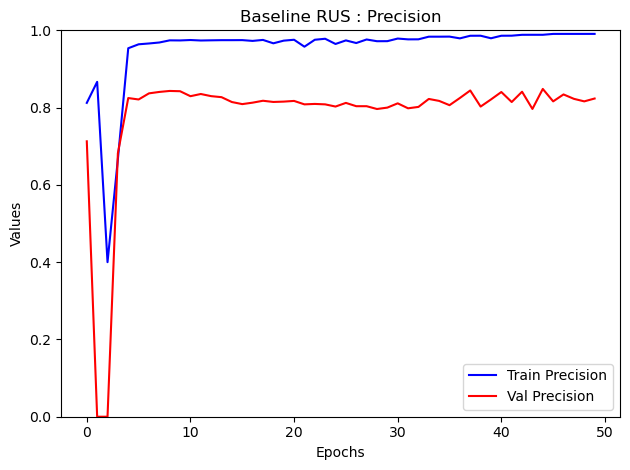

[[0.986014,
  0.986143,
  0.988426,
  0.988479,
  0.988453,
  0.990741,
  0.990783,
  0.990783,
  0.990783,
  0.990805]]

[[0.840376,
  0.81448,
  0.841121,
  0.796537,
  0.848341,
  0.816144,
  0.834101,
  0.822727,
  0.816144,
  0.823529]]

In [27]:
plt.plot(history.history["precision"], color="b", label="Train Precision")
plt.plot(history.history["val_precision"], color="r", label="Val Precision")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Baseline RUS : Precision")
plt.legend()
plt.ylim(0,1)
save_fig("baseline_rus_precision", "png")
plt.show()

display([[round(f, 6) for f in history.history['precision'][-10:]]])
display([[round(f, 6) for f in history.history['val_precision'][-10:]]])


### Recall

Saving figure baseline_rus_recall


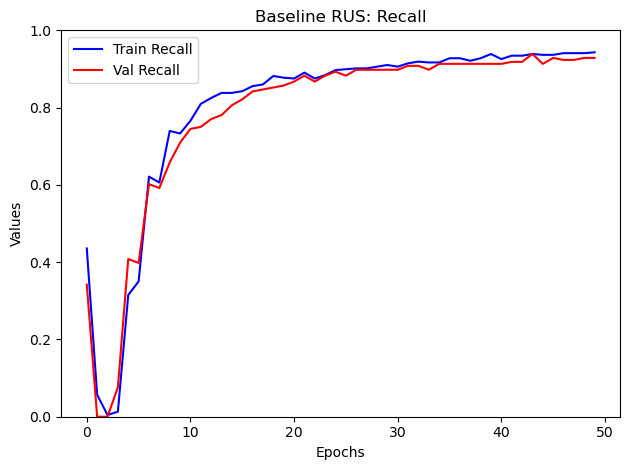

[[0.925602,
  0.934354,
  0.934354,
  0.938731,
  0.936543,
  0.936543,
  0.940919,
  0.940919,
  0.940919,
  0.943107]]

[[0.913265,
  0.918367,
  0.918367,
  0.938776,
  0.913265,
  0.928571,
  0.923469,
  0.923469,
  0.928571,
  0.928571]]

In [28]:
plt.plot(history.history["recall"], color="b", label="Train Recall")
plt.plot(history.history["val_recall"], color="r", label="Val Recall")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Baseline RUS: Recall")
plt.legend()
plt.ylim(0,1)
save_fig("baseline_rus_recall", "png")
plt.show()

display([[round(f, 6) for f in history.history['recall'][-10:]]])
display([[round(f, 6) for f in history.history['val_recall'][-10:]]])


In [29]:
def f1_calculus(name, rec, prec):
    df_tmp=pd.DataFrame()
    df_tmp[name] = 2*np.array(rec)*np.array(prec)/(np.array(rec)+np.array(prec)+tf.keras.backend.epsilon()) # epsilon avoid runtimeWarning: divide by zero encountered in divide...
    return df_tmp

### F1 Score

Saving figure baseline_rus_f1


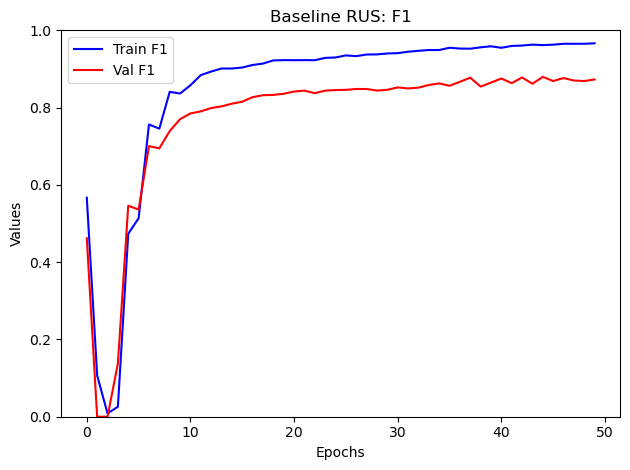

,f1
40,0.954853
41,0.959551
42,0.960630
43,0.962963
44,0.961798
45,0.962880
46,0.965208
47,0.965208
48,0.965208
49,0.966368


,val_f1
40,0.875306
41,0.863309
42,0.878049
43,0.861827
44,0.879607
45,0.868735
46,0.876513
47,0.870192
48,0.868735
49,0.872902


In [30]:
df_tmp = f1_calculus("f1", history.history["recall"], history.history["precision"])
df_val_tmp = f1_calculus("val_f1", history.history["val_recall"], history.history["val_precision"])

plt.plot(df_tmp["f1"], color="b", label="Train F1")
plt.plot(df_val_tmp["val_f1"], color="r", label="Val F1")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Baseline RUS: F1")
plt.legend()
plt.ylim(0,1)
save_fig("baseline_rus_f1", "png")
plt.show()

display(df_tmp.tail(10))
display(df_val_tmp.tail(10))




### Confusion matrix (animated)

In [31]:
def plot_confusion_matrices(confusion_matrices):
    epochs = range(1, k_epochs + 1)
    frames = []

    # Create a frame per epoch
    for epoch, cm in zip(epochs, confusion_matrices):
        annotations = [[f'{value}' for value in row] for row in cm]
        frame = go.Frame(data=[go.Heatmap(
            z=cm, 
            text=annotations,
            colorscale='Viridis',                       # mimic default color of sklearn.metrics.confusion_matrix()
            hoverinfo='skip',                           # ! Hide hover info (x, y, z)
            showscale=True,                             # colorbar visible
            texttemplate="%{text}",                     # string to be displayed in the cells
            textfont={"size": 14},  
        )], name=f"Epoch {epoch}")
        frames.append(frame)

    # Initialization with the first confusion matrix
    fig = go.Figure(
        data=[go.Heatmap(
            z=confusion_matrices[0], 
            text=[[f'{value}' for value in row] for row in confusion_matrices[0]], 
            colorscale='Viridis',
            hoverinfo='skip',  
            showscale=True,  
            texttemplate="%{text}",  
            textfont={"size": 14},  
        )],
        layout=go.Layout(
            autosize=False,
            width=1000,
            height=1000,
            title="Animated confusion matrix",
            xaxis_title="Predicted label",
            yaxis_title="True Label",
            # Make sure 0 is on top and 1 is bottom on y axis 
            # Make sure we read "Ham" and "Spam"
            xaxis=dict(
                tickvals=[0, 1], 
                ticktext=["Ham", "Spam"]
            ),
            yaxis=dict(
                tickvals=[0, 1],  
                ticktext=["Spam", "Ham"],  
                categoryorder="array",  
                categoryarray=[1, 0]  
            ),
            updatemenus=[{
                'type': 'buttons',
                'buttons': [{
                    'label': 'Play',
                    'method': 'animate',
                    'args': [None, {
                        'frame': {'duration': 500, 'redraw': True},
                        'fromcurrent': True,
                        'mode': 'immediate',
                    }]
                }]
            }]
        ),
        frames=frames  # assign frames to the Figure
    )

    # Add a slider
    fig.update_layout(
        sliders=[{
            'steps': [{
                'args': [[f"Epoch {epoch}"], {'frame': {'duration': 500, 'redraw': True}}],
                'label': f'Epoch {epoch}',
                'method': 'animate'
            } for epoch in epochs],
            'currentvalue': {'prefix': 'Epoch: '}
        }]
    )
    fig.show()

plot_confusion_matrices(confusion_matrices)